In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import missingno as msno
import sweetviz as sv
import pandas as pd

<h1>Reading in the Data</h1>

In [2]:
data = pd.read_csv('train.csv', index_col=False)
labels = pd.read_csv('train-labels.csv', index_col=False)

In [3]:
def modify_data(data, labels=None):
    updated_data = pd.DataFrame(data)

    # Encode all the nominal data
    labeler = LabelEncoder()

    if labels is not None:
        updated_data['class'] = labeler.fit_transform(labels['status_group'])
        print(labeler.classes_)

    updated_data['funder'] = labeler.fit_transform(data['funder'])
    updated_data['installer'] = labeler.fit_transform(data['installer'])
    updated_data['region'] = labeler.fit_transform(data['region'])
    updated_data['lga'] = labeler.fit_transform(data['lga'])
    updated_data['ward'] = labeler.fit_transform(data['ward'])
    updated_data['basin'] = labeler.fit_transform(data['basin'])
    updated_data['recorded_by'] = labeler.fit_transform(data['recorded_by'])
    updated_data['extraction_type'] = labeler.fit_transform(data['extraction_type'])
    updated_data['extraction_type_group'] = labeler.fit_transform(data['extraction_type_group'])
    updated_data['extraction_type_class'] = labeler.fit_transform(data['extraction_type_class'])
    updated_data['management'] = labeler.fit_transform(data['management'])
    updated_data['management_group'] = labeler.fit_transform(data['management_group'])
    updated_data['payment'] = labeler.fit_transform(data['payment'])
    updated_data['payment_type'] = labeler.fit_transform(data['payment_type'])
    updated_data['water_quality'] = labeler.fit_transform(data['water_quality'])
    updated_data['quality_group'] = labeler.fit_transform(data['quality_group'])
    updated_data['quantity'] = labeler.fit_transform(data['quantity'])
    updated_data['quantity_group'] = labeler.fit_transform(data['quantity_group'])
    updated_data['source'] = labeler.fit_transform(data['source'])
    updated_data['source_type'] = labeler.fit_transform(data['source_type'])
    updated_data['source_class'] = labeler.fit_transform(data['source_class'])
    updated_data['waterpoint_type'] = labeler.fit_transform(data['waterpoint_type'])
    updated_data['waterpoint_type_group'] = labeler.fit_transform(data['waterpoint_type_group'])

    # Scale the continous data
    scaler = StandardScaler()

    updated_data['amount_tsh'] = scaler.fit_transform(data['amount_tsh'].array.reshape(-1,1))
    updated_data['num_private'] = scaler.fit_transform(data['num_private'].array.reshape(-1,1))
    updated_data['population'] = scaler.fit_transform(data['population'].array.reshape(-1,1))

    # Drop unique / missing data points
    updated_data = updated_data.drop(columns=['scheme_name', 'public_meeting', 'scheme_management', 'date_recorded', 'wpt_name',
                                          'subvillage', 'region_code', 'district_code', 'ward', 'construction_year'])
    # Fill NaNs
    updated_data.permit = updated_data.permit.fillna(False)

    return updated_data

In [4]:
updated_data = modify_data(data, labels)

['functional' 'functional needs repair' 'non functional']


In [5]:
# Column to drop scheme_name
# msno.matrix(updated_data)

In [6]:
# msno.bar(updated_data)

<h1>Data Visualization</h1>

In [8]:
labels['class'] = updated_data['class']
X_train, X_test, y_train, y_test = train_test_split(updated_data.drop(columns=['class']), labels['class'], test_size=0.25, random_state=16, shuffle=True)
# comparison_report = sv.compare([X_train, "Train"], [X_test, "Test"], target_feat="class", feat_cfg=sv.FeatureConfig(force_num=['class']))
# comparison_report.show_notebook()

In [16]:
from sklearn.decomposition import PCA

n = 2

pca = PCA(n_components = n)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
print(explained_variance.sum())
pca_df = pd.DataFrame(pca.components_,columns=updated_data.columns,index = [f'PC-{i}' for i in range(n)]).abs()


0.9987221875664763


ValueError: Shape of passed values is (2, 31), indices imply (2, 30)

In [10]:
# print(pca_df.idxmax(axis=1, numeric_only=False))

In [11]:
pca_only_df = pd.DataFrame()
pca_only_df['installer'] = updated_data['installer']
pca_only_df['gps_height'] = updated_data['gps_height']
pca_only_df['funder'] = updated_data['funder']
pca_only_df['lga'] = updated_data['lga']
pca_only_df['longitude'] = updated_data['longitude']
pca_only_df['extraction_type'] = updated_data['extraction_type']
# pca_only_df['class'] = updated_data['class']

<h1>Model Training</h1>

----- MLPClassifier -----
Accuracy: 0.5630
F1 Score: 0.4330


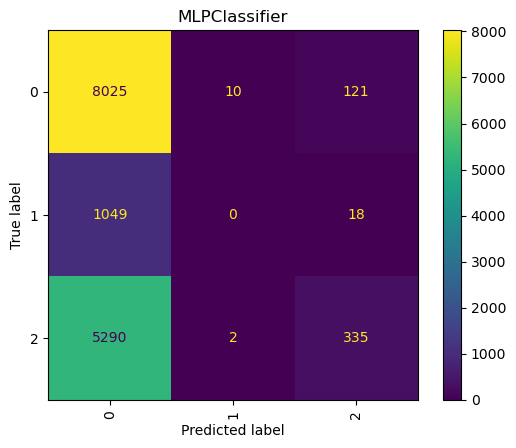

----- RandomForestClassifier -----
Accuracy: 0.8056
F1 Score: 0.7986


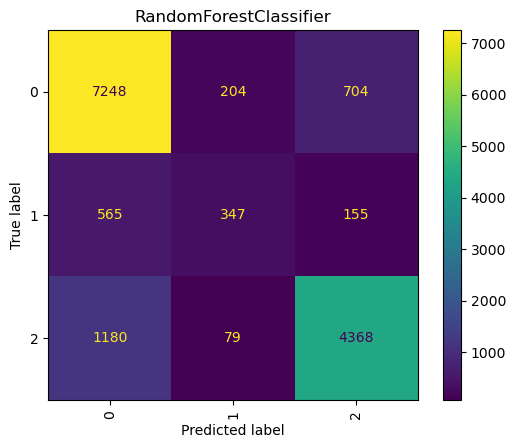

----- XGBClassifier -----
Accuracy: 0.7958
F1 Score: 0.7832


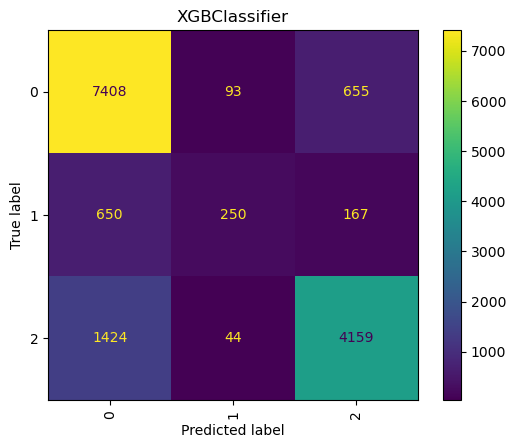

----- KNeighborsClassifier -----
Accuracy: 0.5539
F1 Score: 0.5182


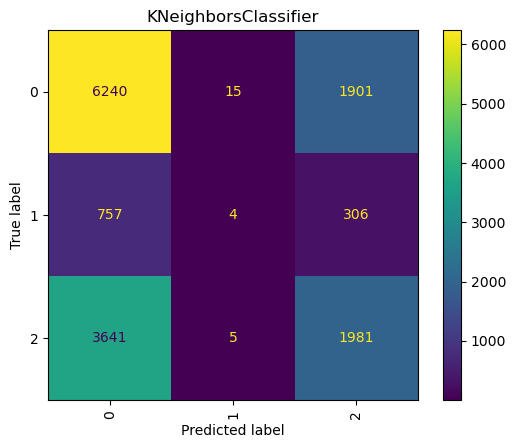

----- HistGradientBoosingClassifier -----
Accuracy: 0.7893
F1 Score: 0.7755


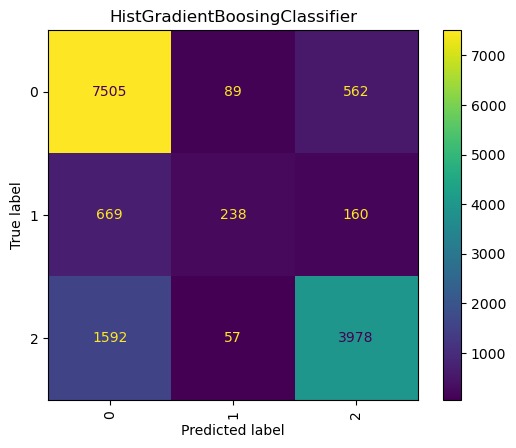

----- Ensemble -----
Accuracy: 0.7988
F1 Score: 0.7803


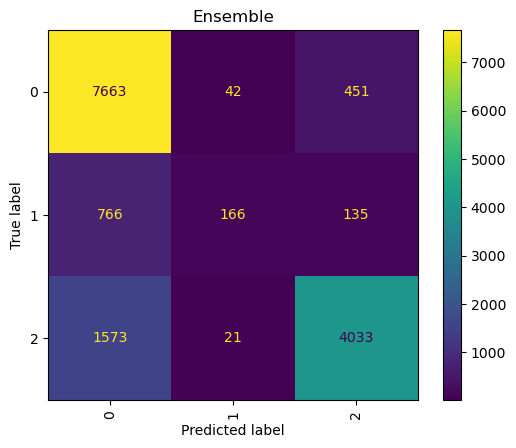

In [12]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(updated_data.drop(columns=['class']), labels['class'], test_size=0.25, random_state=16, shuffle=True)

models = {
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, max_iter=300, shuffle=True, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": xgb.XGBClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=45, weights="distance"),
    "HistGradientBoosingClassifier": HistGradientBoostingClassifier()
}

# Adding the ensemble model
ensemble_clf = VotingClassifier(estimators=[
    ('mlp', models['MLPClassifier']),
    ('rf', models['RandomForestClassifier']),
    ('xgb', models['XGBClassifier']),
    ('knn', models['KNeighborsClassifier']),
    ('hgb', models['HistGradientBoosingClassifier'])
], voting='soft', weights=[1, 1, 2, 1, 1])

models["Ensemble"] = ensemble_clf

# Evaluating each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"----- {name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0','1','2'])
    disp.plot()
    plt.xticks(rotation=90)
    plt.title(name)
    plt.show()

<h1>Model Predictions</h1>

In [13]:
import numpy as np
test = pd.read_csv('test.csv')
normalized_test = modify_data(test)

In [14]:
predictions = []
for name, model in models.items():
    y_pred = model.predict(normalized_test)
    predictions.append(y_pred)

In [21]:
best_predictions = predictions[1]
word_predictions = []

# ['functional' 'functional needs repair' 'non functional']

for pred in best_predictions:
    if pred == 0:
        word_predictions.append('functional')
    elif pred == 1:
        word_predictions.append('functional needs repair')
    else:
        word_predictions.append('non functional')

word_predictions = np.array(word_predictions)

best_predictions = word_predictions.reshape(-1,1)

test_id = normalized_test['id'].array.reshape(-1,1)
submission_array = np.concatenate([test_id, best_predictions], axis=1)

In [22]:
pd.DataFrame(submission_array, columns=['id', 'status_group']).to_csv('submission3.csv',index=False)

<h1>Data Oversampling</h1>

In [5]:
labels = updated_data['class']
updated_data = updated_data.drop(columns=['class'])
# updated_data, labels

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_sampled, y_sampled = smote.fit_resample(updated_data, labels)
X_sampled['class'] = y_sampled

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled.drop(columns=['class']), y_sampled, test_size=0.25, random_state=16, shuffle=True)
# comparison_report = sv.compare([X_train, "Train"], [X_test, "Test"], target_feat="class", feat_cfg=sv.FeatureConfig(force_num=['class']))
# comparison_report.show_notebook()

In [10]:
from sklearn.decomposition import PCA

n = 10

pca = PCA(n_components = n)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
print(explained_variance.sum())
pca_df = pd.DataFrame(pca.components_,columns=updated_data.columns,index = [f'PC-{i}' for i in range(n)]).abs()


0.9999999477964568


In [11]:
print(pca_df.idxmax(axis=1, numeric_only=False))

PC-0             id
PC-1      installer
PC-2     gps_height
PC-3         funder
PC-4            lga
PC-5      longitude
PC-6         region
PC-7         region
PC-8    source_type
PC-9       latitude
dtype: object


----- MLPClassifier -----
Accuracy: 0.5260
F1 Score: 0.4900


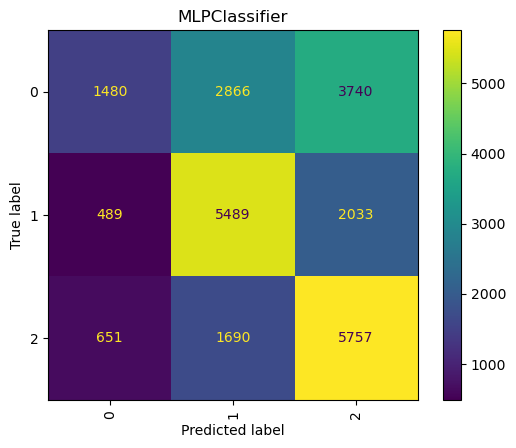

----- RandomForestClassifier -----
Accuracy: 0.8472
F1 Score: 0.8466


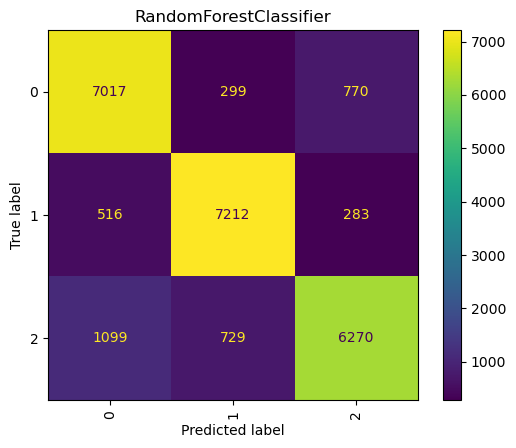

----- XGBClassifier -----
Accuracy: 0.8314
F1 Score: 0.8307


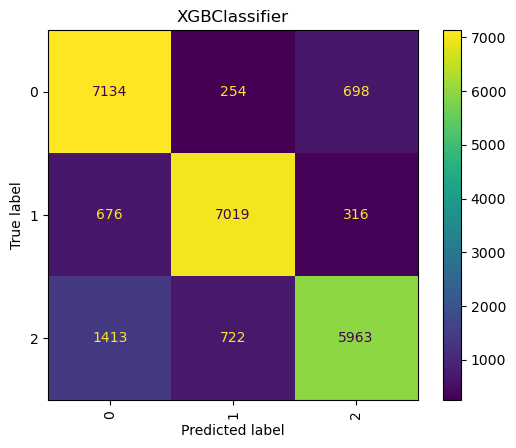

----- KNeighborsClassifier -----
Accuracy: 0.5850
F1 Score: 0.5640


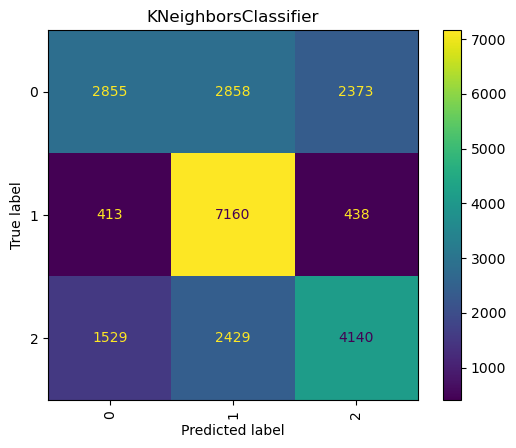

----- HistGradientBoosingClassifier -----
Accuracy: 0.8191
F1 Score: 0.8180


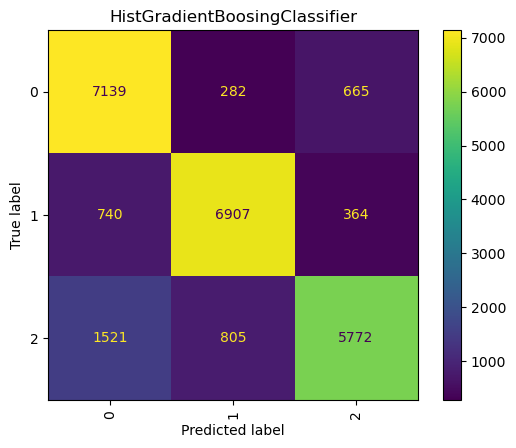

----- Ensemble -----
Accuracy: 0.8469
F1 Score: 0.8461


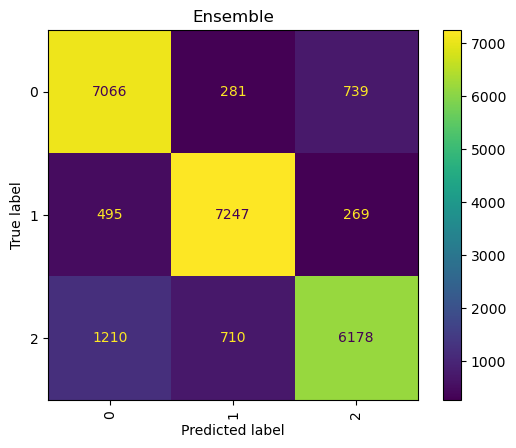

In [12]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb

# X_train, X_test, y_train, y_test = train_test_split(updated_data.drop(columns=['class']), labels['class'], test_size=0.25, random_state=16, shuffle=True)

models = {
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, max_iter=300, shuffle=True, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": xgb.XGBClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=45, weights="distance"),
    "HistGradientBoosingClassifier": HistGradientBoostingClassifier()
}

# Adding the ensemble model
ensemble_clf = VotingClassifier(estimators=[
    ('mlp', models['MLPClassifier']),
    ('rf', models['RandomForestClassifier']),
    ('xgb', models['XGBClassifier']),
    ('knn', models['KNeighborsClassifier']),
    ('hgb', models['HistGradientBoosingClassifier'])
], voting='soft', weights=[1, 1, 2, 1, 1])

models["Ensemble"] = ensemble_clf

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"----- {name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0','1','2'])
    disp.plot()
    plt.xticks(rotation=90)
    plt.title(name)
    plt.show()